In [39]:
import os 

import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set()
sns.set(style="ticks", context="talk")

from scipy import signal
from scipy.io import wavfile
import wave
import struct

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [2]:
two_up =  os.path.abspath(os.path.join('.' ,"../.."))
print("Project root path is: ", two_up)


dataDirName = "data"
rawDataDirName = "test_data"
className = "simple_sine"
data_path = os.path.join(two_up, dataDirName, rawDataDirName, className)

Project root path is:  D:\Programming\AudioMining


Generate a sound sample

In [13]:
# frequency is the number of times a wave repeats a second
 
frequency = 1000
num_samples = 48000
 
# The sampling rate of the analog to digital convert
sampling_rate = 48000.0
amplitude = 16000 
file = "test.wav"

In [14]:
sine_wave = [np.sin(2 * np.pi * frequency * x/sampling_rate) for x in range(num_samples)]


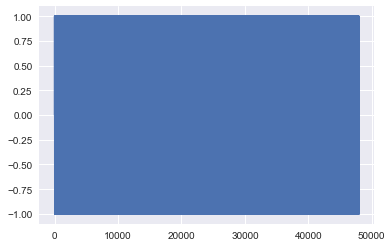

In [15]:
plt.plot(sine_wave)

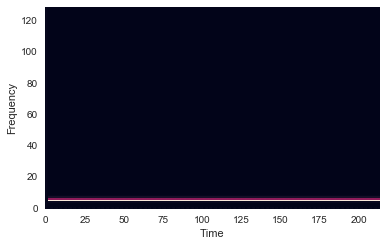

In [29]:
# zoomed in spectrogram
frequencies, times, spectrogram = signal.spectrogram(np.array(sine_wave), sampling_rate)

# all spectrogram
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.show()

In [16]:
nframes=num_samples 
comptype="NONE"
compname="not compressed" 
nchannels=1
sampwidth=2

Save signal to file

In [17]:
wav_file = wave.open(os.path.join(data_path, file), 'w')
wav_file.setparams((nchannels, sampwidth, int(sampling_rate), nframes, comptype, compname))

for s in sine_wave:
   wav_file.writeframes(struct.pack('h', int(s*amplitude)))


Open saved file

In [19]:
frame_rate = 48000.0
infile = "test.wav"
num_samples = 48000
 
wav_file = wave.open(os.path.join(data_path, file), 'r')
data = wav_file.readframes(num_samples)
wav_file.close()

In [20]:
data = struct.unpack('{n}h'.format(n=num_samples), data)
data = np.array(data)
data_fft = np.fft.fft(data)

In [22]:
# This will give us the frequency we want
frequencies = np.abs(data_fft)

48000

In [26]:
print("The frequency with highest values is {} Hz".format(np.argmax(frequencies)))

The frequency with highest values is 1000 Hz


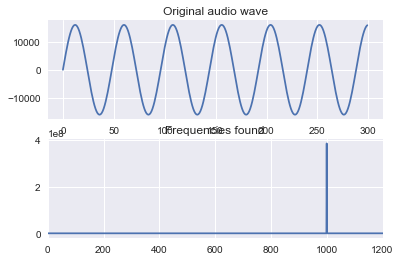

In [27]:
plt.subplot(2,1,1)
plt.plot(data[:300])
plt.title("Original audio wave")
plt.subplot(2,1,2)
plt.plot(frequencies)
plt.title("Frequencies found")
plt.xlim(0,1200)
plt.show()

In [30]:
y, sr = librosa.load(os.path.join(data_path, file), sr=None)

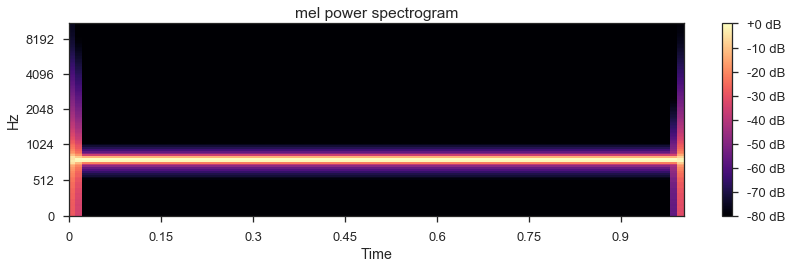

In [40]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

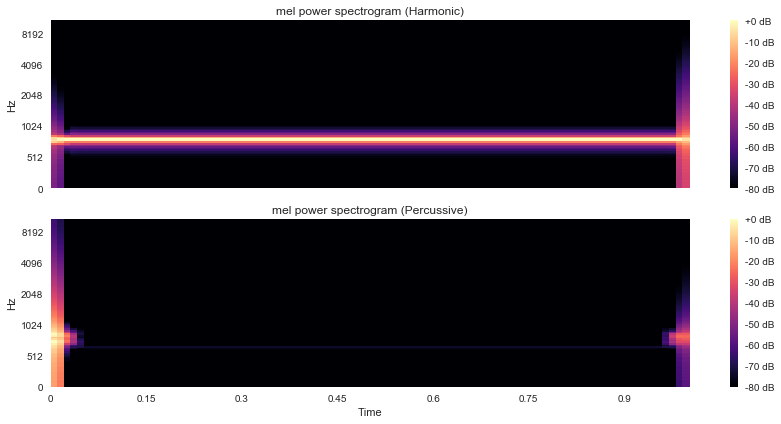

In [32]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()


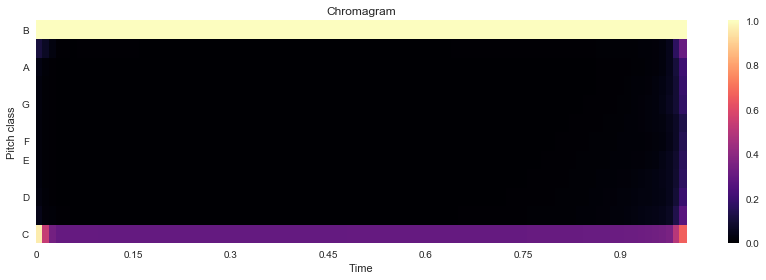

In [33]:
# We'll use a CQT-based chromagram with 36 bins-per-octave in the CQT analysis.  An STFT-based implementation also exists in chroma_stft()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

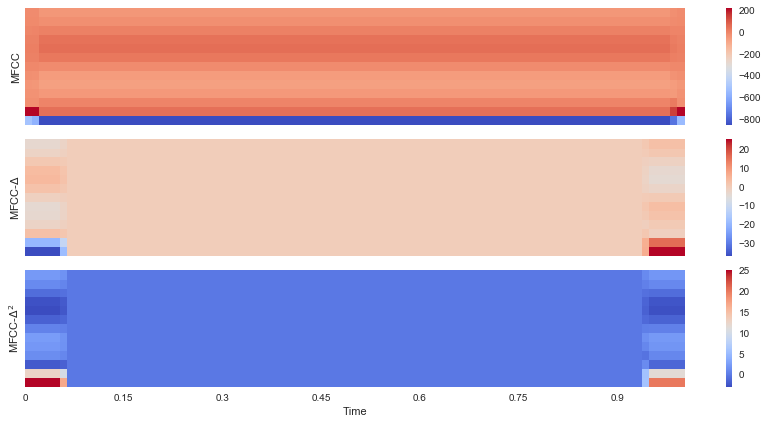

In [34]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

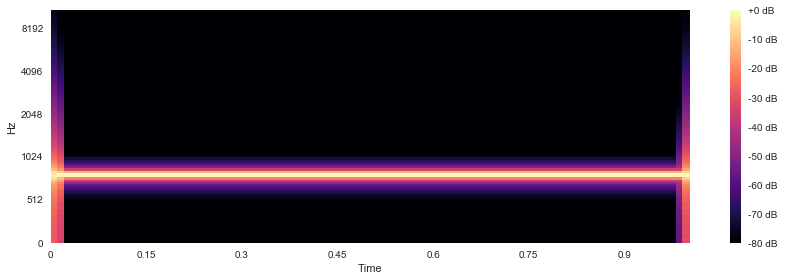

In [35]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout();

In [36]:
print('Estimated tempo:        %.2f BPM' % tempo)
print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        0.00 BPM
First 5 beat frames:    []
First 5 beat times:     []


IndexError: cannot do a non-empty take from an empty axes.

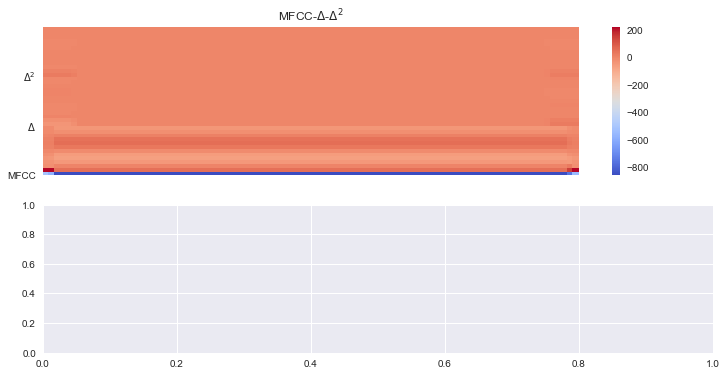

In [37]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

IndexError: cannot do a non-empty take from an empty axes.

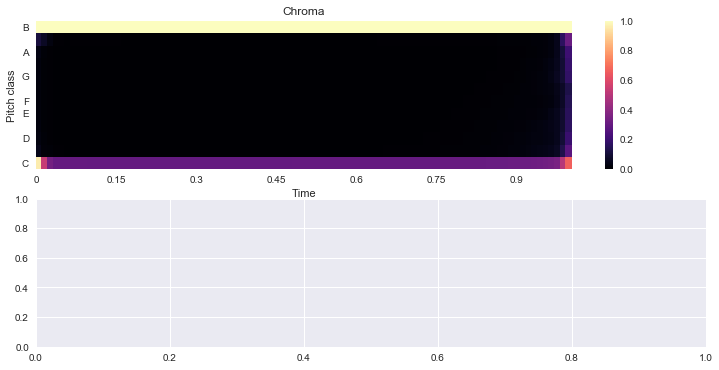

In [38]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()